In [22]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pylab import rcParams
import warnings 
warnings.filterwarnings("ignore")
import nbformat
import calendar
import pickle

In [23]:
df = pd.read_csv('~/Downloads/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [24]:
df = df.fillna(0)

In [25]:
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [26]:
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

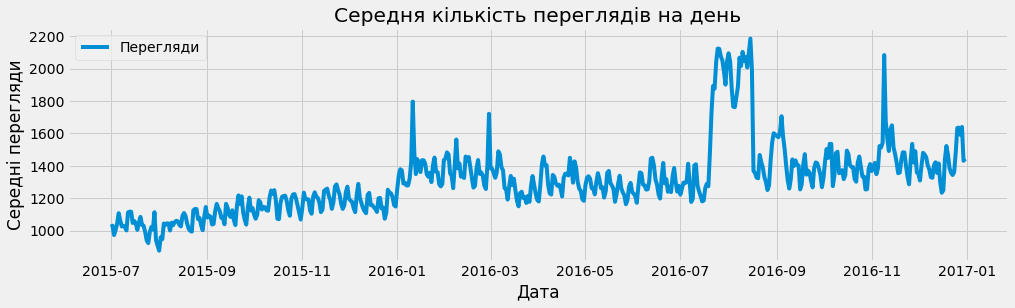

In [27]:
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Дата')
plt.ylabel('Середні перегляди')
plt.title('Середня кількість переглядів на день')
plt.plot(temp,label='Перегляди')
plt.legend()
plt.show()

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (12).

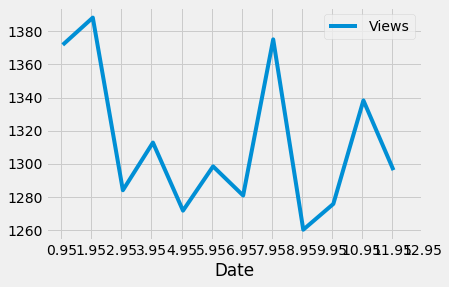

In [31]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Місяць')
ax.set_ylabel('Середні перегляди')
ax.set_title('Середня кількість переглядів на місяць')
plt.show()

In [32]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

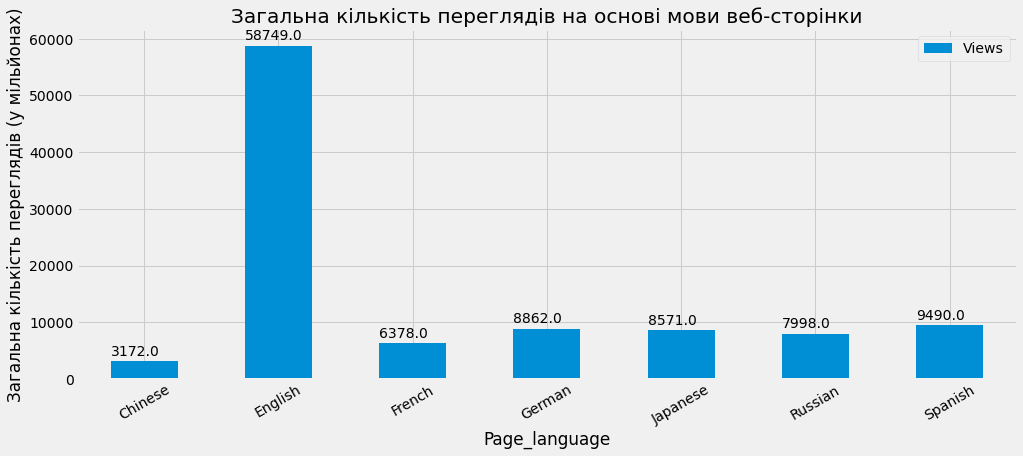

In [35]:
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Загальна кількість переглядів (у мільйонах)')
bar_graph.set_title('Загальна кількість переглядів на основі мови веб-сторінки')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [36]:
days_df = df_reshaped.copy()
days_df = days_df[['Page','Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [37]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
days_df['Day'] = days_df.Dayofweek.apply(find_day)

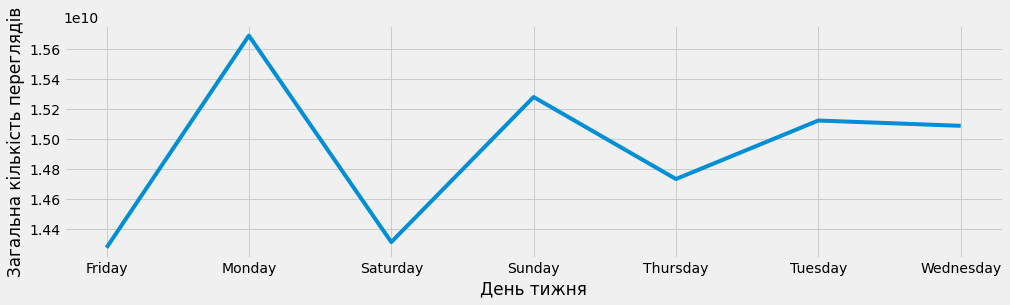

In [38]:
day = days_df.groupby('Day')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('День тижня')
plt.ylabel('Загальна кількість переглядів')
plt.plot(day)
plt.show()

In [39]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

In [40]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

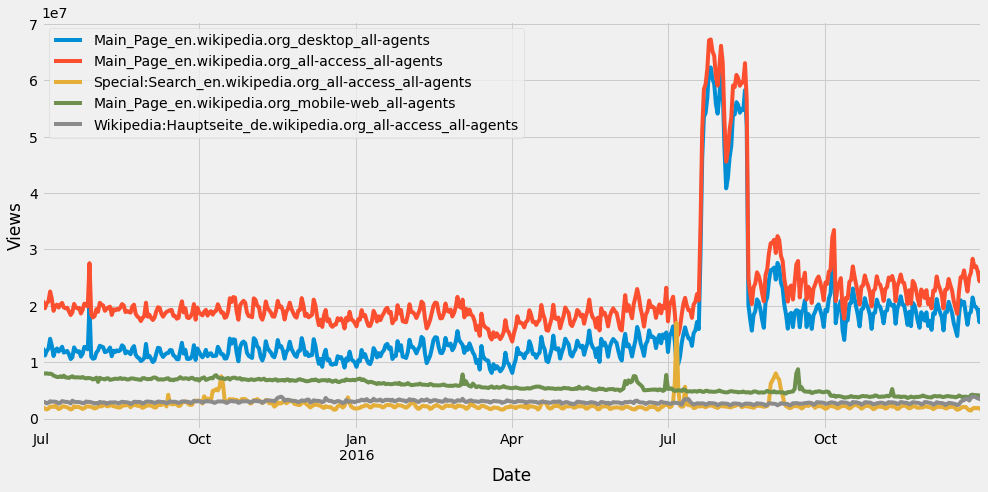

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

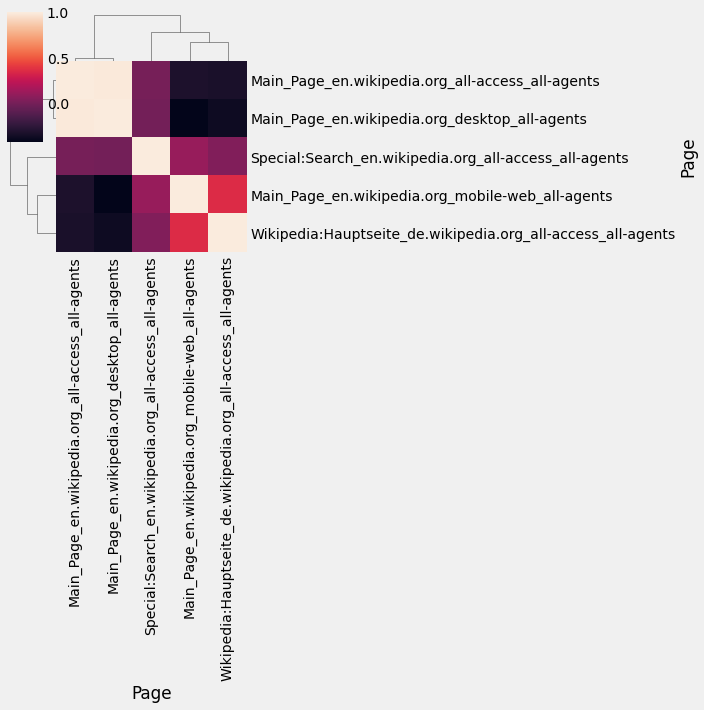

In [42]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [43]:
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


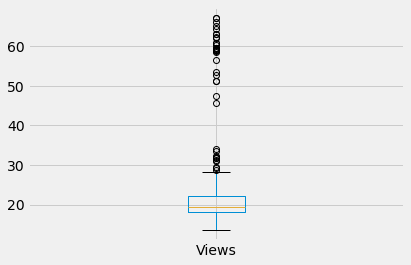

In [44]:
ax1 = top_page_df.boxplot()

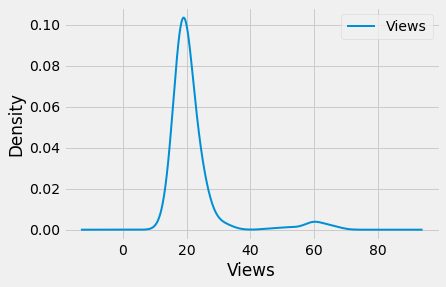

In [45]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

<AxesSubplot:xlabel='Date'>

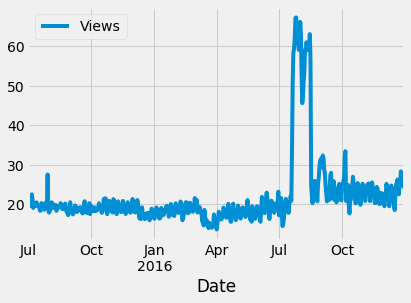

In [46]:
top_page_df.plot()

In [47]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

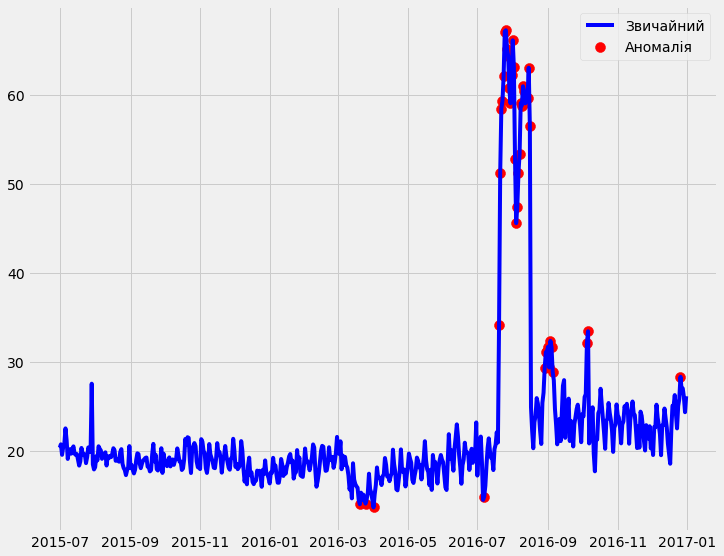

In [49]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Звичайний')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Аномалія')
plt.legend()
plt.show()

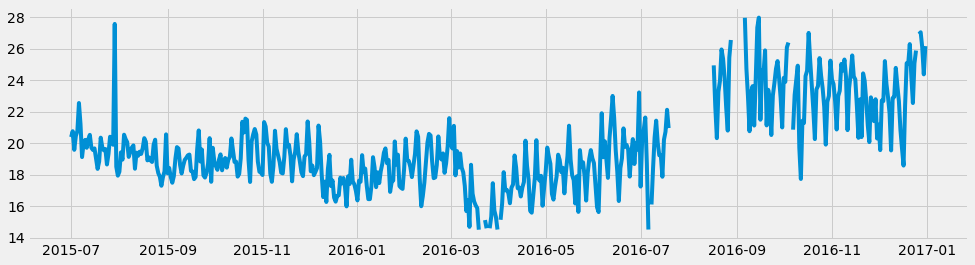

In [50]:
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(15,4))
plt.plot(top_page_df.index,top_page_df.new_views)

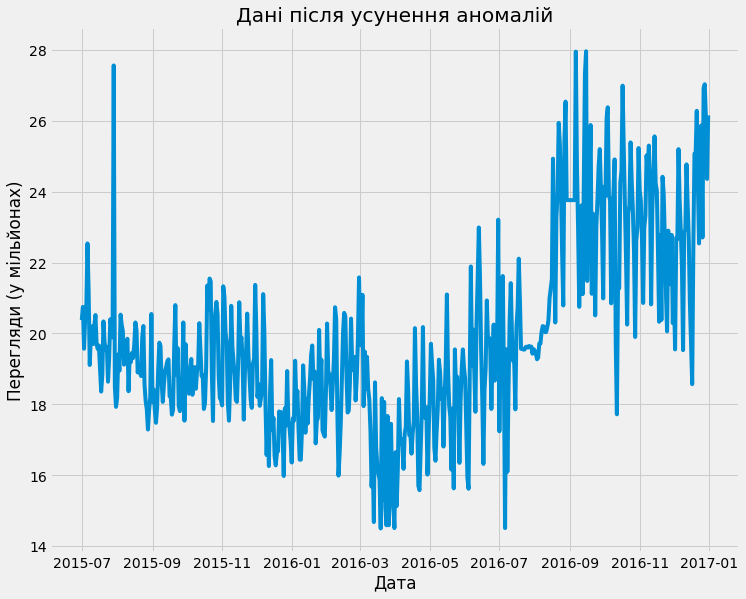

In [52]:
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Дані після усунення аномалій')
plt.xlabel('Дата')
plt.ylabel('Перегляди (у мільйонах)')
plt.show()

In [53]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

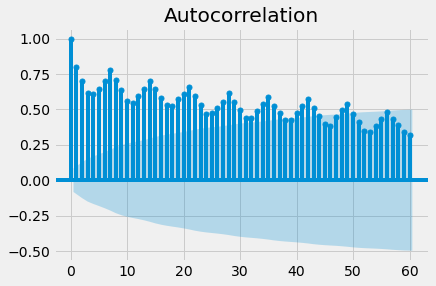

In [54]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

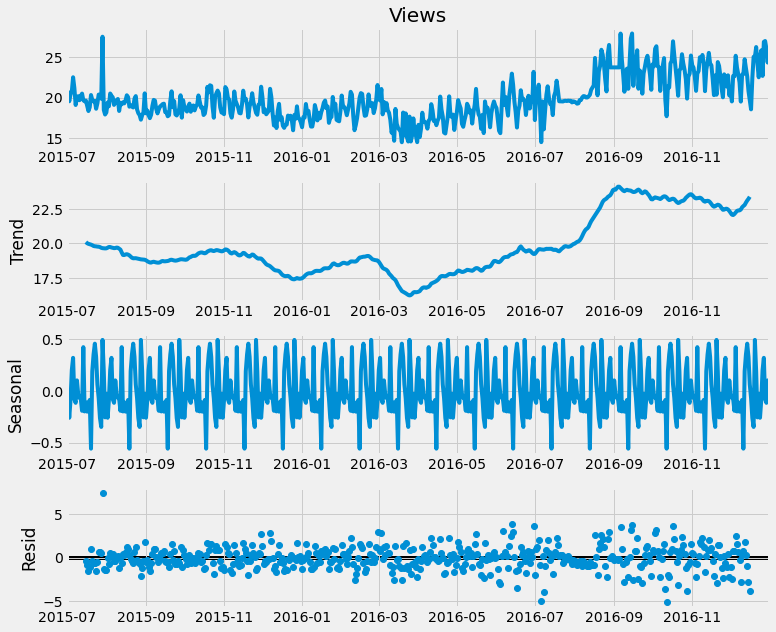

In [55]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views,freq = 30)
figure = ts_decomposition.plot()

In [56]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.543002282404252, 0.8833482337944273, 15, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 1782.4152309149047)


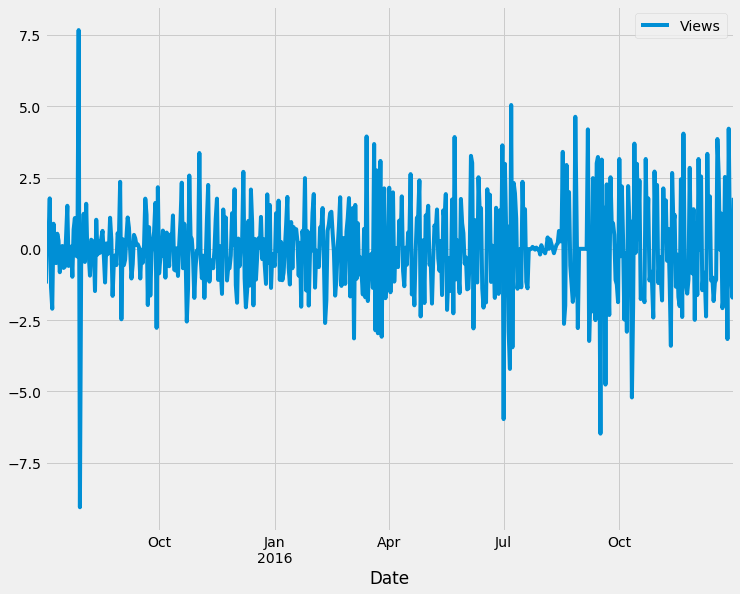

In [57]:
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [58]:
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-7.098637008610511, 4.2244491901788824e-10, 14, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 1778.3909540364323)


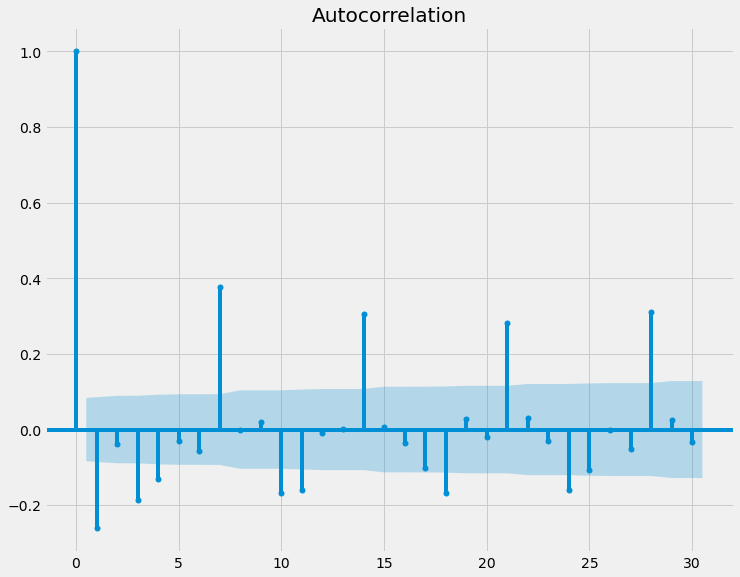

In [59]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

In [60]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

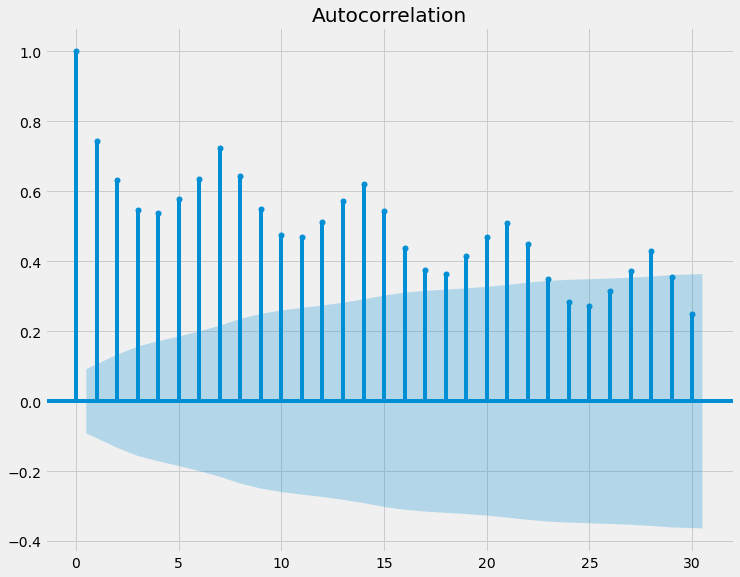

In [61]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

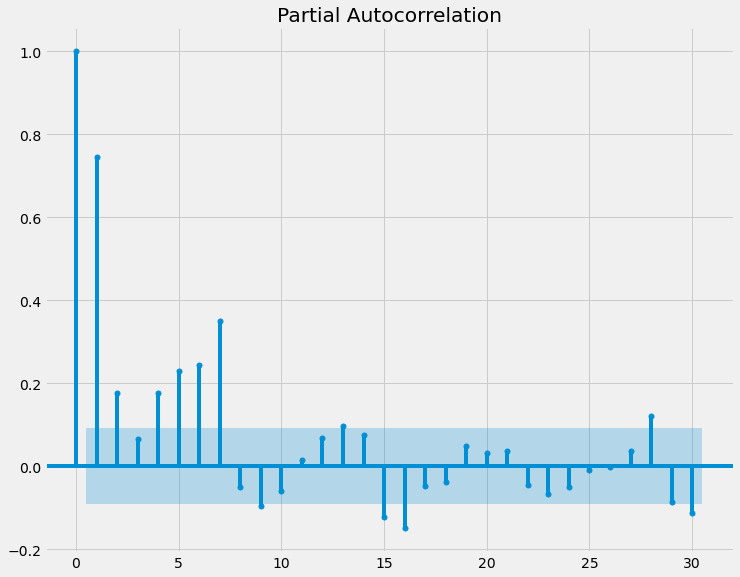

In [62]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

In [63]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

In [64]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

In [65]:
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

In [67]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

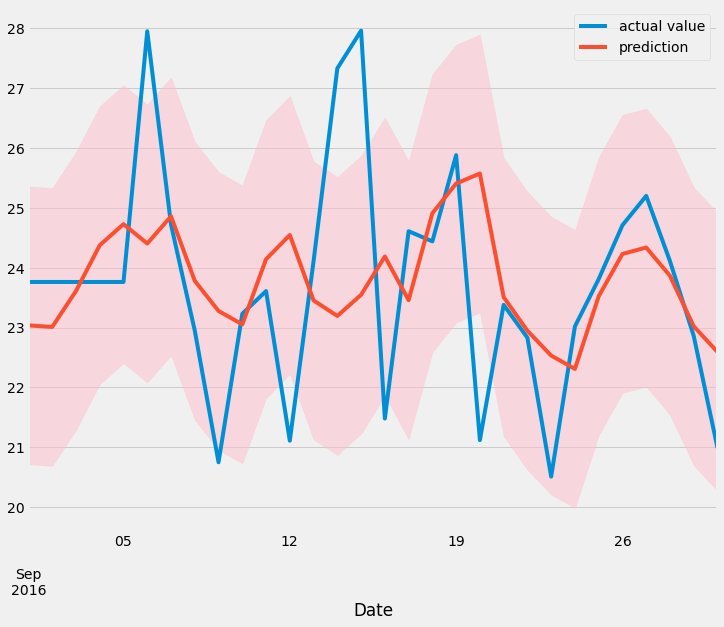

In [68]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

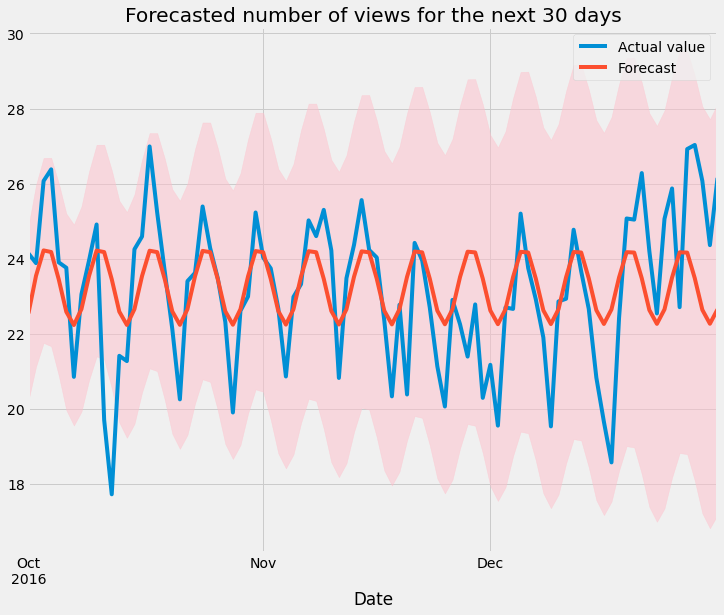

In [69]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [70]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

In [71]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

In [72]:
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

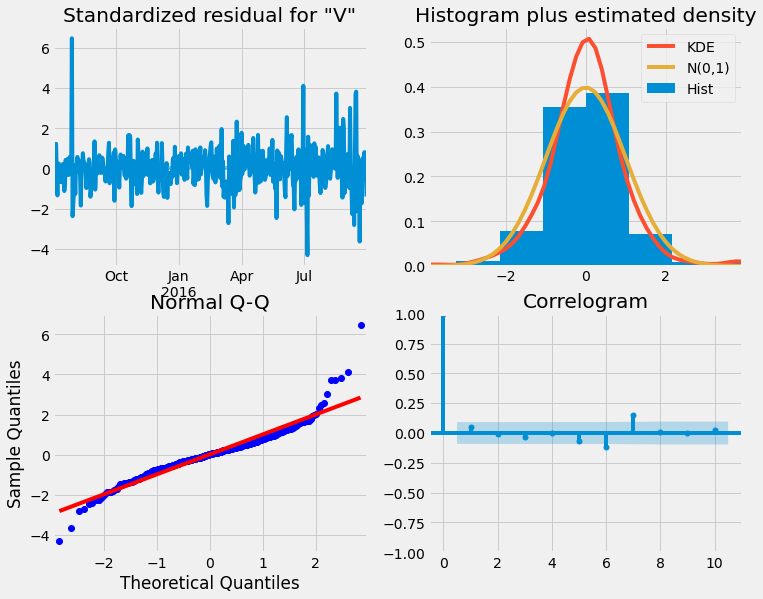

In [74]:
arima_result.plot_diagnostics()
plt.show()

In [75]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -730.061
Date:                Tue, 08 Jun 2021   AIC                           1476.121
Time:                        15:50:22   BIC                           1509.119
Sample:                    07-01-2015   HQIC                          1489.118
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2588      0.032      8.094      0.000       0.196       0.321
ar.L2          0.2311      0.040      5.749      0.000       0.152       0.310
ar.L3         -0.9873      0.032    -30.747      0.000      -1.050      -0.924
ma.L1         -1.0021      0.040    -25.201      0.000      -1.080      -0.924
ma.L2         -0.0685      0.060     -1.142      0.254      -0.186       0.049
ma.L3          1.1694      0.059     19.677      0.000       1.053       1.286
ma.L4         -0.7421      0.034    -21.962      0.000      -0.808      -0.676
sigma2         1.4278      0.053     26.918      0.000       1.324       1.532
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):               744.97
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

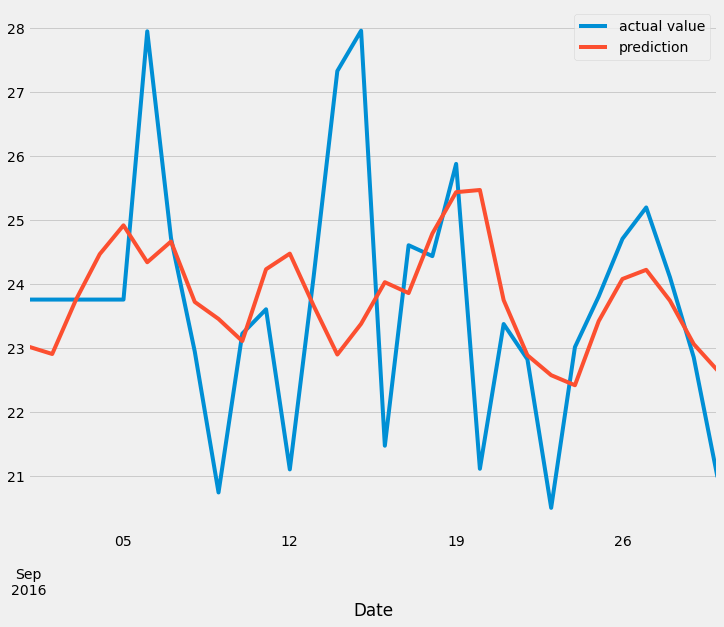

In [76]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

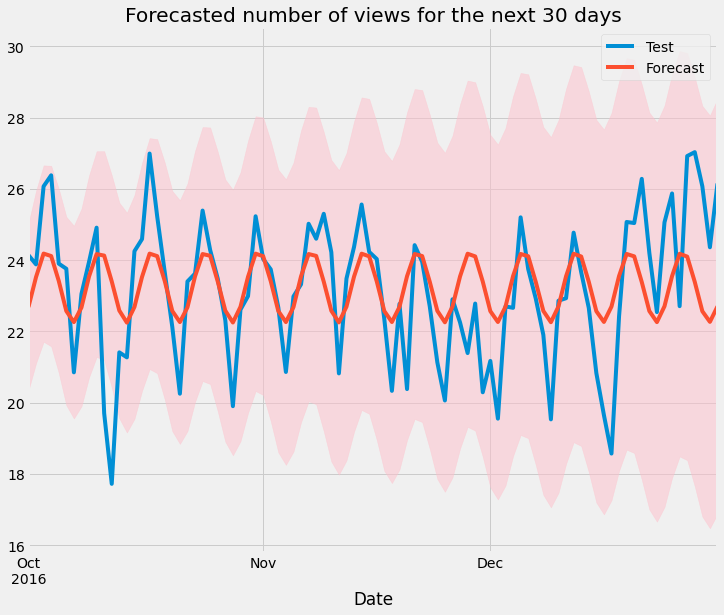

In [77]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [78]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

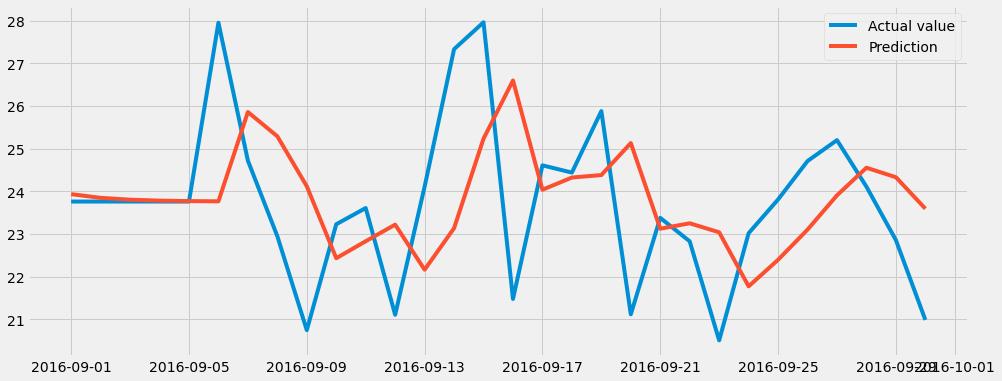

In [79]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(15,6))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

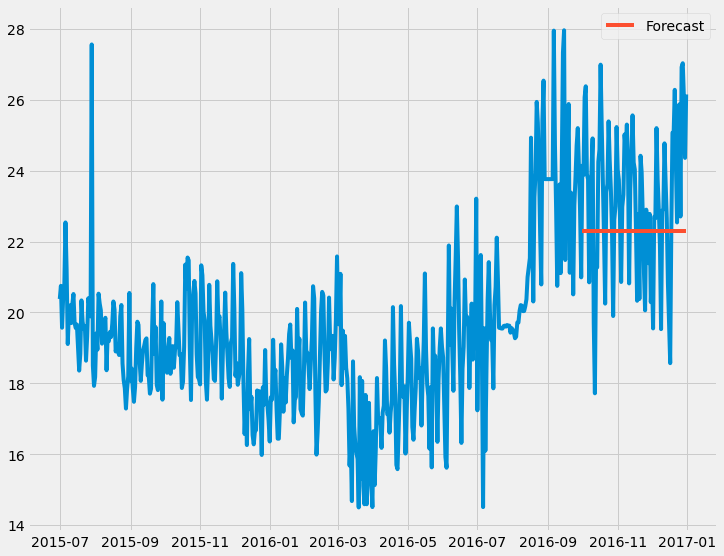

In [81]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()